<a href="https://colab.research.google.com/github/peterbmob/WP2pres/blob/main/neb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast generation of repulsive potentials for tight binding models 
Peter Broqvist, Thijs Smolders, and Jolla Kullgren 


### Let's generate a DFTB+CCS model for Li-CH$_3$H$_4$O$_3$

This notebook takes you all the way from an ASE database with DFT structures to 
a SCC-DFTB+CCS model to be used within ASE. In the example, we will start from the xTB-model. 


<figure>
   <img src="fig1.png" width="550" alt='missing' class="Figure 1"/>
   <figcaption class="figure-caption text-center"><b>Figure 1</b> Initial steps assumed to occur during the breakdown of EC leading to the formation of LEDC and LEMC.</figcaption>
</figure>



In [154]:
ls

CCS_error.out               CCS_params.json  sample_data/     xTBpCCS_val/
CCS_input_interpreted.json  DFT_DB_train.db  structures.json  xTB_run/
CCS_input.json              DFT_DB_val.db    xTBpCCS/


## First, we need to set up the environment and upload the dataset

Requirements: 


In [155]:
!conda --version

conda 22.11.1


In [1]:
# Conda is uninstalled every time you rehash yuor environment... 
#!conda --version
#If !conda --version returns no results, install conda with :
!pip install -q condacolab
import condacolab
condacolab.install()
     

✨🍰✨ Everything looks OK!


In [2]:

!conda --version

conda 22.9.0


In [3]:
%%capture
!conda install -c conda-forge dftbplus ase cvxopt tqdm 

In [166]:
%%capture
##!pip install git+https://github.com/Teoroo-CMC/CCS.git@remove_key_check
!pip install git+https://github.com/yqshao/ase-notebook.git
!pip install pythreejs

In [120]:
from google.colab import files
uploads= files.upload()

Saving DFT_DB_train.db to DFT_DB_train.db


In [121]:
!ase db DFT_DB_train.db

id|age|formula |calculator| energy|natoms|  fmax|pbc|  volume|charge|  mass| smax|magmom
 1|25m|LiC3H4O3|vasp      |-61.512|    11| 5.011|TTT|8400.000| 0.000|95.002|0.001| 1.000
 2|25m|LiC3H4O3|vasp      |-61.687|    11| 5.497|TTT|1100.000| 0.000|95.002|0.005| 1.000
 3|25m|LiC3H4O3|vasp      |-62.269|    11| 2.108|TTT|8400.000| 0.000|95.002|0.001| 1.000
 4|25m|LiC3H4O3|vasp      |-59.518|    11| 6.453|TTT|8400.000| 0.000|95.002|0.001| 0.995
 5|25m|LiC3H4O3|vasp      |-61.942|    11| 2.730|TTT|8400.000| 0.000|95.002|0.000| 1.000
 6|25m|LiC3H4O3|vasp      |-62.632|    11| 0.357|TTT|8400.000| 0.000|95.002|0.000| 0.992
 7|25m|LiC3H4O3|vasp      |-63.291|    11| 2.383|TTT|8400.000| 0.000|95.002|0.000| 1.000
 8|25m|LiC3H4O3|vasp      |-63.603|    11| 0.940|TTT|8400.000| 0.000|95.002|0.000| 1.000
 9|25m|LiC3H4O3|vasp      |-62.615|    11|41.604|TTT|1100.000| 0.000|95.002|0.002| 1.000
10|25m|LiC3H4O3|vasp      |-62.962|    11| 2.077|TTT|8400.000| 0.000|95.002|0.001| 1.000
11|25m|LiC3H4O3|vasp 

# xTB calcualtions on the DB structures


In [122]:
import os 
import sys
from ase import Atoms
from ase.db import connect 
from ase import io
import ase.db 

from ase.optimize import FIRE, QuasiNewton
from ase.io import read, write
import ase.db  
from ase.units import *
import numpy as np

from ccs_fit.ase_calculator.ccs_ase_calculator import CCS

In [109]:
#@title ASE DFTB 
""" This module defines a FileIOCalculator for DFTB+ with XTB 

http://www.dftbplus.org/
http://www.dftb.org/

Initial development: markus.kaukonen@iki.fi, Modified to be used with xTB. 
"""

import os
import numpy as np
from ase.calculators.calculator import (FileIOCalculator, kpts2ndarray,
                                        kpts2sizeandoffsets)
from ase.units import Hartree, Bohr


class Dftb_xtb(FileIOCalculator):

    command = 'dftb+ > PREFIX.out'

    implemented_properties = ['energy', 'forces', 'charges',
                              'stress', 'dipole']
    discard_results_on_any_change = True

    def __init__(self, restart=None,
                 ignore_bad_restart_file=FileIOCalculator._deprecated,
                 label='dftb', atoms=None, kpts=None,
                 slako_dir=None,
                 **kwargs):
        """
        All keywords for the dftb_in.hsd input file (see the DFTB+ manual)
        can be set by ASE. Consider the following input file block:

        >>> Hamiltonian = DFTB {
        >>>     SCC = Yes
        >>>     SCCTolerance = 1e-8
        >>>     MaxAngularMomentum = {
        >>>         H = s
        >>>         O = p
        >>>     }
        >>> }

        This can be generated by the DFTB+ calculator by using the
        following settings:

        >>> calc = Dftb(Hamiltonian_='DFTB',  # line is included by default
        >>>             Hamiltonian_SCC='Yes',
        >>>             Hamiltonian_SCCTolerance=1e-8,
        >>>             Hamiltonian_MaxAngularMomentum_='',
        >>>             Hamiltonian_MaxAngularMomentum_H='s',
        >>>             Hamiltonian_MaxAngularMomentum_O='p')

        In addition to keywords specific to DFTB+, also the following keywords
        arguments can be used:

        restart: str
            Prefix for restart file.  May contain a directory.
            Default is None: don't restart.
        ignore_bad_restart_file: bool
            Ignore broken or missing restart file. By default, it is an
            error if the restart file is missing or broken.
        label: str (default 'dftb')
            Prefix used for the main output file (.out).
        atoms: Atoms object (default None)
            Optional Atoms object to which the calculator will be
            attached. When restarting, atoms will get its positions and
            unit-cell updated from file.
        kpts: (default None)
            Brillouin zone sampling:

            * ``(1,1,1)`` or ``None``: Gamma-point only
            * ``(n1,n2,n3)``: Monkhorst-Pack grid
            * ``dict``: Interpreted as a path in the Brillouin zone if
              it contains the 'path_' keyword. Otherwise it is converted
              into a Monkhorst-Pack grid using
              ``ase.calculators.calculator.kpts2sizeandoffsets``
            * ``[(k11,k12,k13),(k21,k22,k23),...]``: Explicit (Nkpts x 3)
              array of k-points in units of the reciprocal lattice vectors
              (each with equal weight)

        Additional attribute to be set by the embed() method:

        pcpot: PointCharge object
            An external point charge potential (for QM/MM calculations)
        """

        #if slako_dir is None:
            #slako_dir = os.environ.get('DFTB_PREFIX', './')
            #if not slako_dir.endswith('/'):
            #    slako_dir += '/'

        #self.slako_dir = slako_dir

        self.default_parameters = dict(
            Hamiltonian_='DFTB',
         #   Hamiltonian_SlaterKosterFiles_='Type2FileNames',
         #   Hamiltonian_SlaterKosterFiles_Prefix=self.slako_dir,
         #  Hamiltonian_SlaterKosterFiles_Separator='"-"',
         #   Hamiltonian_SlaterKosterFiles_Suffix='".skf"',
         #   Hamiltonian_MaxAngularMomentum_='',
            Paralell_='',
            Paralell_UseOmpThreads = 'Yes', 
            Analysis_='',  
            Analysis_CalculateForces = 'Yes',   
            Options_='',
            Options_WriteResultsTag='Yes')
   

        self.pcpot = None
        self.lines = None
        self.atoms = None
        self.atoms_input = None
        self.do_forces = True 
        self.outfilename = 'dftb.out'

        FileIOCalculator.__init__(self, restart, ignore_bad_restart_file,
                                  label, atoms,
                                  **kwargs)

        # Determine number of spin channels
        try:
            entry = kwargs['Hamiltonian_SpinPolarisation']
            spinpol = 'colinear' in entry.lower()
        except KeyError:
            spinpol = False
        self.nspin = 2 if spinpol else 1

        # kpoint stuff by ase
        self.kpts = kpts
        self.kpts_coord = None

        if self.kpts is not None:
            initkey = 'Hamiltonian_KPointsAndWeights'
            mp_mesh = None
            offsets = None

            if isinstance(self.kpts, dict):
                if 'path' in self.kpts:
                    # kpts is path in Brillouin zone
                    self.parameters[initkey + '_'] = 'Klines '
                    self.kpts_coord = kpts2ndarray(self.kpts, atoms=atoms)
                else:
                    # kpts is (implicit) definition of
                    # Monkhorst-Pack grid
                    self.parameters[initkey + '_'] = 'SupercellFolding '
                    mp_mesh, offsets = kpts2sizeandoffsets(atoms=atoms,
                                                           **self.kpts)
            elif np.array(self.kpts).ndim == 1:
                # kpts is Monkhorst-Pack grid
                self.parameters[initkey + '_'] = 'SupercellFolding '
                mp_mesh = self.kpts
                offsets = [0.] * 3
            elif np.array(self.kpts).ndim == 2:
                # kpts is (N x 3) list/array of k-point coordinates
                # each will be given equal weight
                self.parameters[initkey + '_'] = ''
                self.kpts_coord = np.array(self.kpts)
            else:
                raise ValueError('Illegal kpts definition:' + str(self.kpts))

            if mp_mesh is not None:
                eps = 1e-10
                for i in range(3):
                    key = initkey + '_empty%03d' % i
                    val = [mp_mesh[i] if j == i else 0 for j in range(3)]
                    self.parameters[key] = ' '.join(map(str, val))
                    offsets[i] *= mp_mesh[i]
                    assert abs(offsets[i]) < eps or abs(offsets[i] - 0.5) < eps
                    # DFTB+ uses a different offset convention, where
                    # the k-point mesh is already Gamma-centered prior
                    # to the addition of any offsets
                    if mp_mesh[i] % 2 == 0:
                        offsets[i] += 0.5
                key = initkey + '_empty%03d' % 3
                self.parameters[key] = ' '.join(map(str, offsets))

            elif self.kpts_coord is not None:
                for i, c in enumerate(self.kpts_coord):
                    key = initkey + '_empty%09d' % i
                    c_str = ' '.join(map(str, c))
                    if 'Klines' in self.parameters[initkey + '_']:
                        c_str = '1 ' + c_str
                    else:
                        c_str += ' 1.0'
                    self.parameters[key] = c_str

    def write_dftb_in(self, outfile):
        """ Write the innput file for the dftb+ calculation.
            Geometry is taken always from the file 'geo_end.gen'.
        """

        outfile.write('Geometry = GenFormat { \n')
        outfile.write('    <<< "geo_end.gen" \n')
        outfile.write('} \n')
        outfile.write(' \n')

        params = self.parameters.copy()

        #s = 'Hamiltonian_MaxAngularMomentum_'
        #for key in params:
        #    if key.startswith(s) and len(key) > len(s):
        #        break
        #else:
            # User didn't specify max angular mometa.  Get them from
            # the .skf files:
        #    symbols = set(self.atoms.get_chemical_symbols())
        #    for symbol in symbols:
        #        path = os.path.join(self.slako_dir,
        #                            '{0}-{0}.skf'.format(symbol))
        #        l = read_max_angular_momentum(path)
        #        params[s + symbol] = '"{}"'.format('spdf'[l])

        # --------MAIN KEYWORDS-------
        previous_key = 'dummy_'
        myspace = ' '
        for key, value in sorted(params.items()):
            current_depth = key.rstrip('_').count('_')
            previous_depth = previous_key.rstrip('_').count('_')
            for my_backsclash in reversed(
                    range(previous_depth - current_depth)):
                outfile.write(3 * (1 + my_backsclash) * myspace + '} \n')
            outfile.write(3 * current_depth * myspace)
            if key.endswith('_') and len(value) > 0:
                outfile.write(key.rstrip('_').rsplit('_')[-1] +
                              ' = ' + str(value) + '{ \n')
            elif (key.endswith('_') and (len(value) == 0)
                  and current_depth == 0):  # E.g. 'Options {'
                outfile.write(key.rstrip('_').rsplit('_')[-1] +
                              ' ' + str(value) + '{ \n')
            elif (key.endswith('_') and (len(value) == 0)
                  and current_depth > 0):  # E.g. 'Hamiltonian_Max... = {'
                outfile.write(key.rstrip('_').rsplit('_')[-1] +
                              ' = ' + str(value) + '{ \n')
            elif key.count('_empty') == 1:
                outfile.write(str(value) + ' \n')
            elif ((key == 'Hamiltonian_ReadInitialCharges') and
                  (str(value).upper() == 'YES')):
                f1 = os.path.isfile(self.directory + os.sep + 'charges.dat')
                f2 = os.path.isfile(self.directory + os.sep + 'charges.bin')
                if not (f1 or f2):
                    print('charges.dat or .bin not found, switching off guess')
                    value = 'No'
                outfile.write(key.rsplit('_')[-1] + ' = ' + str(value) + ' \n')
            else:
                outfile.write(key.rsplit('_')[-1] + ' = ' + str(value) + ' \n')
            if self.pcpot is not None and ('DFTB' in str(value)):
                outfile.write('   ElectricField = { \n')
                outfile.write('      PointCharges = { \n')
                outfile.write(
                    '         CoordsAndCharges [Angstrom] = DirectRead { \n')
                outfile.write('            Records = ' +
                              str(len(self.pcpot.mmcharges)) + ' \n')
                outfile.write(
                    '            File = "dftb_external_charges.dat" \n')
                outfile.write('         } \n')
                outfile.write('      } \n')
                outfile.write('   } \n')
            previous_key = key
        current_depth = key.rstrip('_').count('_')
        for my_backsclash in reversed(range(current_depth)):
            outfile.write(3 * my_backsclash * myspace + '} \n')
        outfile.write('ParserOptions { \n')
        outfile.write('   IgnoreUnprocessedNodes = Yes  \n')
        outfile.write('} \n')
        if self.do_forces:
            outfile.write('Analysis { \n')
            outfile.write('   CalculateForces = Yes  \n')
            outfile.write('} \n')

    def check_state(self, atoms):
        system_changes = FileIOCalculator.check_state(self, atoms)
        # Ignore unit cell for molecules:
        if not atoms.pbc.any() and 'cell' in system_changes:
            system_changes.remove('cell')
        if self.pcpot and self.pcpot.mmpositions is not None:
            system_changes.append('positions')
        return system_changes

    def write_input(self, atoms, properties=None, system_changes=None):
        from ase.io import write
        if properties is not None:
            if 'forces' in properties or 'stress' in properties:
                self.do_forces = True
        FileIOCalculator.write_input(
            self, atoms, properties, system_changes)
        with open(os.path.join(self.directory, 'dftb_in.hsd'), 'w') as fd:
            self.write_dftb_in(fd)
        write(os.path.join(self.directory, 'geo_end.gen'), atoms,
              parallel=False)
        # self.atoms is none until results are read out,
        # then it is set to the ones at writing input
        self.atoms_input = atoms
        self.atoms = None
        if self.pcpot:
            self.pcpot.write_mmcharges('dftb_external_charges.dat')

    def read_results(self):
        """ all results are read from results.tag file
            It will be destroyed after it is read to avoid
            reading it once again after some runtime error """

        with open(os.path.join(self.directory, 'results.tag'), 'r') as fd:
            self.lines = fd.readlines()

        self.atoms = self.atoms_input
        charges, energy, dipole = self.read_charges_energy_dipole()
        if charges is not None:
            self.results['charges'] = charges
        self.results['energy'] = energy
        if dipole is not None:
            self.results['dipole'] = dipole
        if self.do_forces:
            forces = self.read_forces()
            self.results['forces'] = forces
        self.mmpositions = None

        # stress stuff begins
        sstring = 'stress'
        have_stress = False
        stress = list()
        for iline, line in enumerate(self.lines):
            if sstring in line:
                have_stress = True
                start = iline + 1
                end = start + 3
                for i in range(start, end):
                    cell = [float(x) for x in self.lines[i].split()]
                    stress.append(cell)
        if have_stress:
            stress = -np.array(stress) * Hartree / Bohr**3
            self.results['stress'] = stress.flat[[0, 4, 8, 5, 2, 1]]
        # stress stuff ends

        # eigenvalues and fermi levels
        fermi_levels = self.read_fermi_levels()
        if fermi_levels is not None:
            self.results['fermi_levels'] = fermi_levels

        eigenvalues = self.read_eigenvalues()
        if eigenvalues is not None:
            self.results['eigenvalues'] = eigenvalues

        # calculation was carried out with atoms written in write_input
        os.remove(os.path.join(self.directory, 'results.tag'))

    def read_forces(self):
        """Read Forces from dftb output file (results.tag)."""
        from ase.units import Hartree, Bohr

        # Initialise the indices so their scope
        # reaches outside of the for loop
        index_force_begin = -1
        index_force_end = -1

        # Force line indexes
        for iline, line in enumerate(self.lines):
            fstring = 'forces   '
            if line.find(fstring) >= 0:
                index_force_begin = iline + 1
                line1 = line.replace(':', ',')
                index_force_end = iline + 1 + \
                    int(line1.split(',')[-1])
                break

        gradients = []
        for j in range(index_force_begin, index_force_end):
            word = self.lines[j].split()
            gradients.append([float(word[k]) for k in range(0, 3)])

        return np.array(gradients) * Hartree / Bohr

    def read_charges_energy_dipole(self):
        """Get partial charges on atoms
            in case we cannot find charges they are set to None
        """
        with open(os.path.join(self.directory, 'detailed.out'), 'r') as fd:
            lines = fd.readlines()

        for line in lines:
            if line.strip().startswith('Total energy:'):
                energy = float(line.split()[2]) * Hartree
                break

        qm_charges = []
        for n, line in enumerate(lines):
            if ('Atom' and 'Charge' in line):
                chargestart = n + 1
                break
        else:
            # print('Warning: did not find DFTB-charges')
            # print('This is ok if flag SCC=No')
            return None, energy, None

        lines1 = lines[chargestart:(chargestart + len(self.atoms))]
        for line in lines1:
            qm_charges.append(float(line.split()[-1]))

        dipole = None
        for line in lines:
            if 'Dipole moment:' in line and 'au' in line:
                words = line.split()
                dipole = np.array(
                    [float(w) for w in words[-4:-1]]) * Bohr

        return np.array(qm_charges), energy, dipole

    def get_charges(self, atoms):
        """ Get the calculated charges
        this is inhereted to atoms object """
        if 'charges' in self.results:
            return self.results['charges']
        else:
            return None

    def read_eigenvalues(self):
        """ Read Eigenvalues from dftb output file (results.tag).
            Unfortunately, the order seems to be scrambled. """
        # Eigenvalue line indexes
        index_eig_begin = None
        for iline, line in enumerate(self.lines):
            fstring = 'eigenvalues   '
            if line.find(fstring) >= 0:
                index_eig_begin = iline + 1
                line1 = line.replace(':', ',')
                ncol, nband, nkpt, nspin = map(int, line1.split(',')[-4:])
                break
        else:
            return None

        # Take into account that the last row may lack
        # columns if nkpt * nspin * nband % ncol != 0
        nrow = int(np.ceil(nkpt * nspin * nband * 1. / ncol))
        index_eig_end = index_eig_begin + nrow
        ncol_last = len(self.lines[index_eig_end - 1].split())
        self.lines[index_eig_end - 1] += ' 0.0 ' * (ncol - ncol_last)

        eig = np.loadtxt(self.lines[index_eig_begin:index_eig_end]).flatten()
        eig *= Hartree
        N = nkpt * nband
        eigenvalues = [eig[i * N:(i + 1) * N].reshape((nkpt, nband))
                       for i in range(nspin)]

        return eigenvalues

    def read_fermi_levels(self):
        """ Read Fermi level(s) from dftb output file (results.tag). """
        # Fermi level line indexes
        for iline, line in enumerate(self.lines):
            fstring = 'fermi_level   '
            if line.find(fstring) >= 0:
                index_fermi = iline + 1
                break
        else:
            return None

        fermi_levels = []
        words = self.lines[index_fermi].split()
        assert len(words) in [1, 2], 'Expected either 1 or 2 Fermi levels'

        for word in words:
            e = float(word)
            # In non-spin-polarized calculations with DFTB+ v17.1,
            # two Fermi levels are given, with the second one being 0,
            # but we don't want to add that one to the list
            if abs(e) > 1e-8:
                fermi_levels.append(e)

        return np.array(fermi_levels) * Hartree

    def get_ibz_k_points(self):
        return self.kpts_coord.copy()

    def get_number_of_spins(self):
        return self.nspin

    def get_eigenvalues(self, kpt=0, spin=0):
        return self.results['eigenvalues'][spin][kpt].copy()

    def get_fermi_levels(self):
        return self.results['fermi_levels'].copy()

    def get_fermi_level(self):
        return max(self.get_fermi_levels())

    def embed(self, mmcharges=None, directory='./'):
        """Embed atoms in point-charges (mmcharges)
        """
        self.pcpot = PointChargePotential(mmcharges, self.directory)
        return self.pcpot



class PointChargePotential:
    def __init__(self, mmcharges, directory='./'):
        """Point-charge potential for DFTB+.
        """
        self.mmcharges = mmcharges
        self.directory = directory
        self.mmpositions = None
        self.mmforces = None

    def set_positions(self, mmpositions):
        self.mmpositions = mmpositions

    def set_charges(self, mmcharges):
        self.mmcharges = mmcharges

    def write_mmcharges(self, filename):
        """ mok all
        write external charges as monopoles for dftb+.

        """
        if self.mmcharges is None:
            print("DFTB: Warning: not writing exernal charges ")
            return
        with open(os.path.join(self.directory, filename), 'w') as charge_file:
            for [pos, charge] in zip(self.mmpositions, self.mmcharges):
                [x, y, z] = pos
                charge_file.write('%12.6f %12.6f %12.6f %12.6f \n'
                                  % (x, y, z, charge))

    def get_forces(self, calc, get_forces=True):
        """ returns forces on point charges if the flag get_forces=True """
        if get_forces:
            return self.read_forces_on_pointcharges()
        else:
            return np.zeros_like(self.mmpositions)

    def read_forces_on_pointcharges(self):
        """Read Forces from dftb output file (results.tag)."""
        from ase.units import Hartree, Bohr
        with open(os.path.join(self.directory, 'detailed.out'), 'r') as fd:
            lines = fd.readlines()

        external_forces = []
        for n, line in enumerate(lines):
            if ('Forces on external charges' in line):
                chargestart = n + 1
                break
        else:
            raise RuntimeError(
                'Problem in reading forces on MM external-charges')
        lines1 = lines[chargestart:(chargestart + len(self.mmcharges))]
        for line in lines1:
            external_forces.append(
                [float(i) for i in line.split()])
        return np.array(external_forces) * Hartree / Bohr

def read_max_angular_momentum(path):
    """Read maximum angular momentum from .skf file.

    See dftb.org for A detailed description of the Slater-Koster file format.
    """
    with open(path, 'r') as fd:
        line = fd.readline()
        if line[0] == '@':
            # Extended format
            fd.readline()
            l = 3
            pos = 9
        else:
            # Simple format:
            l = 2
            pos = 7

        # Sometimes there ar commas, sometimes not:
        line = fd.readline().replace(',', ' ')

        occs = [float(f) for f in line.split()[pos:pos + l + 1]]
        for f in occs:
            if f > 0.0:
                return l
            l -= 1


In [108]:
#@title Setup model
def setup_model_xtb(atoms, charge=0,init=True):
    from ase.calculators.mixing import LinearCombinationCalculator

    print('setting up calculator')
    if init==True:
        DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_Mixer= 'Anderson{',Hamiltonian_Mixer_MixingParameter='0.03',Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_Filling = 'MethfesselPaxton{',Hamiltonian_Filling_Temperature = '0.001583407672623195',Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if init==False:
          DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_ReadInitialCharges='Yes', Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_AdaptFillingTemp = 'yes', Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if charge>0: 
        DFTB_calc.set(Hamiltonian_Charge =str(charge))

#    CCS_calc=CCS(CCS_params=CCS_params) 
    calcs =[DFTB_calc] #, PiNN_calc]
    weights=[1] #,1]
    calc=LinearCombinationCalculator(calcs, weights) 
    return calc     


def setup_model_xtb_ccs(atoms, CCS_params, charge=0,init=True):
    from ase.calculators.mixing import LinearCombinationCalculator

    print('setting up calculator')
    if init==True:
        DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_Mixer= 'Anderson{',Hamiltonian_Mixer_MixingParameter='0.03',Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_Filling = 'MethfesselPaxton{',Hamiltonian_Filling_Temperature = '0.001583407672623195',Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if init==False:
          DFTB_calc=Dftb_xtb(label='singlepoint', Hamiltonian_='xTB', Hamiltonian_Method='GFN2-xTB', Hamiltonian_ReadInitialCharges='Yes', Hamiltonian_MaxSCCIterations = '1500',Hamiltonian_AdaptFillingTemp = 'yes', Hamiltonian_KPointsAndWeights = 'SupercellFolding {1 0 0 0 1 0 0 0 1 0.0 0.0 0.0}')
    if charge>0: 
        DFTB_calc.set(Hamiltonian_Charge =str(charge))
    
    CCS_calc=CCS(CCS_params=CCS_params) 
    calcs =[DFTB_calc, CCS_calc]
    weights=[1,1] #,1]
    calc=LinearCombinationCalculator(calcs, weights) 
    return calc     
def run_geom(slab,charge):
    charge=charge
    print(slab.calc)
    relax = FIRE(slab, trajectory='opt.traj')
    relax.run(fmax=0.05)

def run_sp(slab,charge):
    charge=charge
    print(slab.calc)
    relax = FIRE(slab, trajectory='opt.traj')
    relax.run(steps=0)

In [123]:
import os
base = os.getcwd()
try: 
   os.mkdir('xTB_run')
except:
  pass
os.chdir('xTB_run')


In [126]:
## %%capture
db=connect('../DFT_DB_train.db')
db_new=connect('DFTB_DB_train.db')

for row in db.select():
  atoms=row.toatoms()
  print(atoms)
  atoms.calc=setup_model_xtb(atoms)
  atoms.get_potential_energy()
  atoms.get_forces()
  db_new.write(atoms)
  print('Atom id:',row.id,' added')
  

Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], momenta=..., calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 1  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[11.0, 10.0, 10.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 2  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], momenta=..., calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 3  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], momenta=..., calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 4  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 5  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 6  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator

In [127]:
!ase db DFTB_DB_train.db

id|age|formula |calculator                 |  energy|natoms| fmax|pbc|  volume|charge|  mass
 1| 7m|LiC3H4O3|linearcombinationcalculator|-568.037|    11|4.654|TTT|8400.000| 0.000|95.002
 2| 7m|LiC3H4O3|linearcombinationcalculator|-567.884|    11|3.449|TTT|1100.000| 0.000|95.002
 3| 7m|LiC3H4O3|linearcombinationcalculator|-568.370|    11|4.136|TTT|8400.000| 0.000|95.002
 4| 7m|LiC3H4O3|linearcombinationcalculator|-565.129|    11|8.718|TTT|8400.000| 0.000|95.002
 5| 7m|LiC3H4O3|linearcombinationcalculator|-568.124|    11|3.926|TTT|8400.000| 0.000|95.002
 6| 7m|LiC3H4O3|linearcombinationcalculator|-569.060|    11|1.898|TTT|8400.000| 0.000|95.002
 7| 7m|LiC3H4O3|linearcombinationcalculator|-569.610|    11|2.438|TTT|8400.000| 0.000|95.002
 8| 7m|LiC3H4O3|linearcombinationcalculator|-569.690|    11|3.176|TTT|8400.000| 0.000|95.002
 9| 6m|LiC3H4O3|linearcombinationcalculator|-568.677|    11|1.516|TTT|1100.000| 0.000|95.002
10| 6m|LiC3H4O3|linearcombinationcalculator|-568.861|    11|4.080|TTT|

In [128]:
from google.colab import files
files.download('DFTB_DB_train.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [129]:
os.chdir(base)

Text(0, 0.5, 'xTB (eV/atom)')

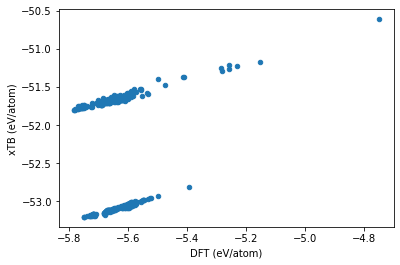

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
os.chdir(base)
Databases = ['DFT_DB_train.db', 'xTB_run/DFTB_DB_train.db']

dd=pd.DataFrame()
for database in Databases:
  db=connect(database)
  Energy=[]
  for row in db.select(): 
      Energy.append(row.energy/len(row.toatoms()))
  dd[database]=Energy


ax=dd.plot.scatter(x=Databases[0],y=Databases[1])
ax = plt.gca()
#ax.set_aspect(1)
ax.set_xlabel('DFT (eV/atom)')
ax.set_ylabel('xTB (eV/atom)')


#Let's try to use the CCS software to solve the problem

In [131]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch as ccs_fetch
from ccs_fit.fitting.main import twp_fit as ccs_fit
import json

1. First, we fetch the data from the ase databases

In [132]:
ccs_fetch(mode='DFTB', R_c= 6.0, Ns='all', DFT_DB='DFT_DB_train.db', DFTB_DB='xTB_run/DFTB_DB_train.db', include_forces=False)

    Fetching data: 100%|██████████| 400/400 [00:05<00:00, 68.09it/s]


2. Generate a dummy input file

In [133]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "DFTB",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

3. Solve the quadratic programming problem to generate a CCS repulsive potential

In [134]:
#RUN FIT
## %%capture
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['C', 'H', 'Li', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: C-C
    Adding pair: C-H
    Adding pair: C-Li
    Adding pair: C-O
    Adding pair: H-H
    Adding pair: H-Li
    Adding pair: H-O
    Adding pair: Li-Li
    Adding pair: Li-O
    Adding pair: O-O
    Applying monotonous constraints for pair:  C-C
    Applying monotonous constraints for pair:  C-H
    Applying monotonous constraints for pair:  C-Li
    Applying monotonous constraints for pair:  C-O
    Applying monotonous constraints for pair:  H-H
    Applying monotonous constraints for pair:  H-Li
    Applying monotonous constraints for pair:  H-O
    Applying monotonous constraints for pair:  Li-Li
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  O-O
    Merging interval for pair C-C. Number of knots reduced from 356 to 219. 
    Merging interval for pair

    Finding optimum switch: 100%|██████████| 1/1 [00:21<00:00, 21.33s/it]


    The best switch is (219, 342, 392, 365, 189, 365, 400, 38, 370, 283) with mse: 0.011893, corresponding to distances of [3.49 4.4  5.51 4.73 3.46 5.36 5.67 3.51 5.18 4.88] Å for element pairs ['C-C', 'C-H', 'C-Li', 'C-O', 'H-H', 'H-Li', 'H-O', 'Li-Li', 'Li-O', 'O-O'].
    Final root mean square error in energy:  0.009550951163408485  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


4. validate the potential

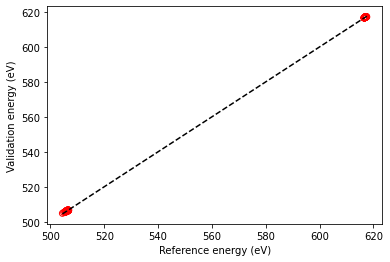

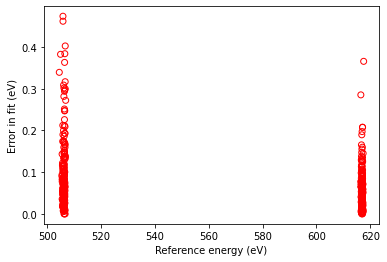

In [135]:
err=np.loadtxt("CCS_error.out")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


In [136]:
try: 
  err=np.loadtxt("CCS_error_forces.out")
  plt.xlabel('Reference forces (eV)')
  plt.ylabel('Validation forces (eV)')
  plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
  plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
  plt.show()
  plt.xlabel('Reference forces (eV)')
  plt.ylabel('Error in fit (eV)')
  plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
  plt.show()
except: 
  pass

# Lets use the new potential

To use the model, we use the LinearCombinationCalculator in ASE. 

In [137]:
try:
  os.mkdir('xTBpCCS')
except: 
  pass 
os.chdir('xTBpCCS')

First, let's use the same data as above. 

In [140]:
## %%capture
import json

db=connect('../DFT_DB_train.db')
db_new=connect('DFTB_CCS_DB_train.db')

with open('../CCS_params.json', 'r') as f:
    CCS_params = json.load(f)

for row in db.select():
  atoms=row.toatoms()
  print(atoms)
  atoms.calc=setup_model_xtb_ccs(atoms, CCS_params)
  atoms.get_potential_energy()
  atoms.get_forces()
  db_new.write(atoms)
  print('Atom id:',row.id,' added')
  

Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], momenta=..., calculator=SinglePointCalculator(...))
setting up calculator


/usr/local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


Atom id: 1  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[11.0, 10.0, 10.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 2  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], momenta=..., calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 3  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], momenta=..., calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 4  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 5  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 6  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 7  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calcu

In [141]:
!ase db DFTB_CCS_DB_train.db

id|age|formula |calculator                 | energy|natoms| fmax|pbc|  volume|charge|  mass
 1| 7m|LiC3H4O3|linearcombinationcalculator|-61.412|    11|5.423|TTT|8400.000| 0.000|95.002
 2| 7m|LiC3H4O3|linearcombinationcalculator|-61.701|    11|5.561|TTT|1100.000| 0.000|95.002
 3| 7m|LiC3H4O3|linearcombinationcalculator|-62.339|    11|2.195|TTT|8400.000| 0.000|95.002
 4| 7m|LiC3H4O3|linearcombinationcalculator|-59.600|    11|6.981|TTT|8400.000| 0.000|95.002
 5| 7m|LiC3H4O3|linearcombinationcalculator|-62.115|    11|2.548|TTT|8400.000| 0.000|95.002
 6| 7m|LiC3H4O3|linearcombinationcalculator|-62.587|    11|4.260|TTT|8400.000| 0.000|95.002
 7| 7m|LiC3H4O3|linearcombinationcalculator|-63.272|    11|2.264|TTT|8400.000| 0.000|95.002
 8| 7m|LiC3H4O3|linearcombinationcalculator|-63.538|    11|1.117|TTT|8400.000| 0.000|95.002
 9| 7m|LiC3H4O3|linearcombinationcalculator|-62.415|    11|1.873|TTT|1100.000| 0.000|95.002
10| 7m|LiC3H4O3|linearcombinationcalculator|-62.883|    11|2.767|TTT|8400.000| 0

In [142]:
from google.colab import files
files.download('DFTB_CCS_DB_train.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

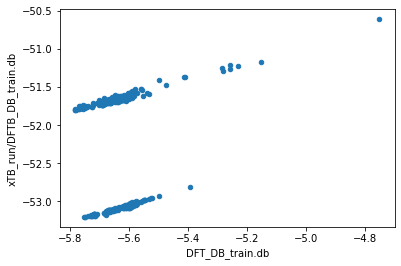

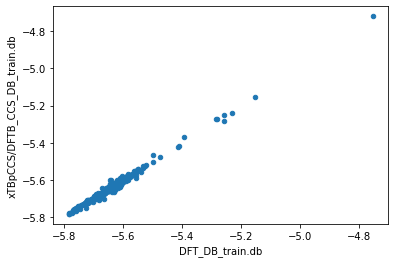

In [143]:
os.chdir(base)
Databases = ['DFT_DB_train.db', 'xTB_run/DFTB_DB_train.db', 'xTBpCCS/DFTB_CCS_DB_train.db']

dd=pd.DataFrame()
for database in Databases:
  db=connect(database)
  Energy=[]
  for row in db.select(): 
      Energy.append(row.energy/len(row.toatoms()))
  dd[database]=Energy


dd.plot.scatter(x=Databases[0],y=Databases[1])
dd.plot.scatter(x=Databases[0],y=Databases[2])

#Let's test it on unseen data 


In [145]:
from google.colab import files
uploads= files.upload()

Saving DFT_DB_val.db to DFT_DB_val.db


In [146]:
try:
  os.mkdir('xTBpCCS_val')
except: 
  pass 
os.chdir('xTBpCCS_val')

In [149]:
db=connect('../DFT_DB_val.db')
db_new=connect('DFTB_CCS_DB_val.db')

with open('../CCS_params.json', 'r') as f:
    CCS_params = json.load(f)

for row in db.select():
  atoms=row.toatoms()
  print(atoms)
  atoms.calc=setup_model_xtb_ccs(atoms, CCS_params)
  try:
    atoms.get_potential_energy()
    atoms.get_forces()
  except:
      pass
  db_new.write(atoms)
  print('Atom id:',row.id,' added')

Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], initial_charges=..., calculator=SinglePointCalculator(...))
setting up calculator


/usr/local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


Atom id: 1  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 2  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[11.0, 10.0, 10.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 3  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 4  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 5  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 6  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 7  added
Atoms(symbols='C3H4LiO3', pbc=True, cell=[21.0, 20.0, 20.0], calculator=SinglePointCalculator(...))
setting up calculator
Atom id: 8  added
At

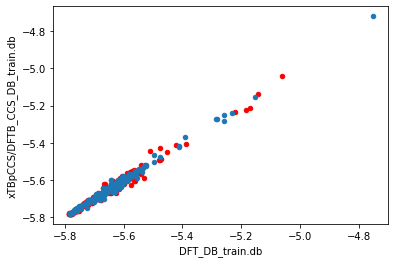

In [157]:
os.chdir(base)
Databases_N = ['DFT_DB_val.db', 'xTBpCCS_val/DFTB_CCS_DB_val.db']
dd_val=pd.DataFrame()
for database in Databases_N:
  db=connect(database)
  Energy=[]
  for row in db.select(): 
      Energy.append(row.energy/len(row.toatoms()))
  dd_val[database]=Energy

ax=dd_val.plot.scatter(x=Databases_N[0],y=Databases_N[1], c='r')
dd.plot.scatter(x=Databases[0],y=Databases[2],ax=ax)


In [153]:
from google.colab import files
files.download('xTBpCCS_val/DFTB_CCS_DB_val.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#xTB for transition states

In [303]:
os.chdir(base)

First, optimize the structures...


In [304]:
try:
  os.mkdir('NEB_cEC-oEC')
except: 
  pass 
os.chdir('NEB_cEC-oEC')

In [305]:
import os
import numpy as np

from ase.neb import NEB
from ase.optimize import BFGS, FIRE
with open('../CCS_params.json', 'r') as f:
    CCS_params = json.load(f)


In [306]:
try:
  os.mkdir('Reactant')
except: 
  pass 
os.chdir('Reactant')


In [161]:
from google.colab import files
uploads= files.upload()

Saving reactant.xyz to reactant.xyz


In [270]:
ls

In [307]:
reactant = io.read('reactant.xyz')
reactant.calc=setup_model_xtb_ccs(reactant, CCS_params, charge=1)
#reactant.calc=setup_model_xtb(reactant)

relax = BFGS(reactant, trajectory='opt.traj')
relax.run(fmax=0.02)

os.chdir(base)

setting up calculator
      Step     Time          Energy         fmax
BFGS:    0 15:32:16      -54.765933        2.1669


/usr/local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


BFGS:    1 15:32:17      -54.832732        1.2600
BFGS:    2 15:32:18      -54.882835        0.8360
BFGS:    3 15:32:20      -54.928894        0.6411
BFGS:    4 15:32:20      -54.950019        0.3835
BFGS:    5 15:32:22      -54.960132        0.3687
BFGS:    6 15:32:23      -54.968789        0.4119
BFGS:    7 15:32:23      -54.975576        0.2230
BFGS:    8 15:32:24      -54.979012        0.2001
BFGS:    9 15:32:25      -54.982645        0.1991
BFGS:   10 15:32:25      -54.987219        0.2790
BFGS:   11 15:32:26      -54.991807        0.2454
BFGS:   12 15:32:27      -54.995352        0.1793
BFGS:   13 15:32:28      -54.999044        0.1799
BFGS:   14 15:32:29      -55.004950        0.3232
BFGS:   15 15:32:30      -55.015249        0.4434
BFGS:   16 15:32:31      -55.030508        0.4402
BFGS:   17 15:32:31      -55.043037        0.5112
BFGS:   18 15:32:33      -55.055790        0.3180
BFGS:   19 15:32:34      -55.066280        0.4611
BFGS:   20 15:32:35      -55.077325        0.4574


In [283]:
ls

CCS_error.out               DFT_DB_train.db  sample_data/     xTB_run/
CCS_input_interpreted.json  DFT_DB_val.db    structures.json
CCS_input.json              NEB_cEC-oEC/     xTBpCCS/
CCS_params.json             results.tag      xTBpCCS_val/


In [311]:
try:
  os.mkdir('NEB_cEC-oEC')
except: 
  pass 
os.chdir('NEB_cEC-oEC')

In [312]:
try:
  os.mkdir('Product')
except: 
  pass 
os.chdir('Product')


In [286]:
ls

band.out     detailed.out  dftb_pin.hsd  opt.traj     singlepoint.out
charges.bin  dftb_in.hsd   geo_end.gen   product.xyz


In [313]:
from google.colab import files
uploads= files.upload()

Saving product_2.xyz to product_2.xyz


In [314]:
product = io.read('product_2.xyz')
product.calc=setup_model_xtb_ccs(product, CCS_params, charge=1)
#product.calc=setup_model_xtb(product)

relax = BFGS(product, trajectory='opt.traj')
relax.run(fmax=0.02)

os.chdir(base)

setting up calculator
      Step     Time          Energy         fmax
BFGS:    0 15:39:07      -50.731993        3.7743
BFGS:    1 15:39:07      -51.091113        2.6251
BFGS:    2 15:39:07      -51.285258        1.4624
BFGS:    3 15:39:08      -51.464033        1.6581
BFGS:    4 15:39:09      -51.614736        1.7930
BFGS:    5 15:39:09      -51.897706        1.0635
BFGS:    6 15:39:10      -51.955463        0.9632
BFGS:    7 15:39:11      -52.044443        0.7475
BFGS:    8 15:39:11      -52.112529        0.9341
BFGS:    9 15:39:12      -52.204533        0.7891
BFGS:   10 15:39:12      -52.262125        0.6372
BFGS:   11 15:39:14      -52.303684        0.4400
BFGS:   12 15:39:14      -52.332199        0.4884
BFGS:   13 15:39:15      -52.355773        0.4708
BFGS:   14 15:39:16      -52.380742        0.6119
BFGS:   15 15:39:17      -52.408514        0.6639
BFGS:   16 15:39:17      -52.442452        0.6810
BFGS:   17 15:39:18      -52.486707        1.0481
BFGS:   18 15:39:19      -52.

In [293]:
ls

band.out     detailed.out  dftb_pin.hsd  Product/   results.tag
charges.bin  dftb_in.hsd   geo_end.gen   Reactant/  singlepoint.out


In [315]:
try:
  os.mkdir('NEB_cEC-oEC')
except: 
  pass 
os.chdir('NEB_cEC-oEC')

In [319]:
initial = read('Reactant/opt.traj')
final = read('Product/opt.traj')

images = [initial]
for i in range(5):
    image = initial.copy()
    image.calc = setup_model_xtb_ccs(image, CCS_params, charge=1)
    #image.calc = setup_model_xtb(image)
    images.append(image)
images.append(final)

neb = NEB(images, climb=False)
neb.interpolate('idpp')
qn = FIRE(neb, trajectory='neb.traj')
qn.run(fmax=0.05)


setting up calculator
setting up calculator
setting up calculator
setting up calculator
setting up calculator
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 15:44:26      -25.034244*       5.4697
FIRE:    1 15:44:33      -25.617727*       5.8119
FIRE:    2 15:44:38      -26.202355*       6.2992
FIRE:    3 15:44:45      -26.825865*       6.7205
FIRE:    4 15:44:51      -27.641025*       7.0068
FIRE:    5 15:45:02      -28.627019*       7.1542
FIRE:    6 15:45:07      -29.787480*       7.2524
FIRE:    7 15:45:13      -30.876420*       6.1549
FIRE:    8 15:45:17      -31.048591*       8.2362
FIRE:    9 15:45:24      -30.438803*      20.9266
FIRE:   10 15:45:29      -31.692701*       9.5259
FIRE:   11 15:45:34      -32.291100*       7.4170
FIRE:   12 15:45:40      -32.198692*      37.7725
FIRE:   13 15:45:48      -32.578853*       9.9438
FIRE:   14 15:45:55      -32.675637*       7.7281
FIRE:   15 15:46:00      -32.824361*      

ValueError: ignored

-569.7063452956817
-569.6933481689912
-569.8431983846992
-570.0039485346925
-570.0240441813675


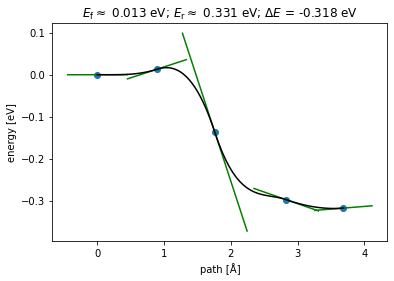

In [244]:
import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read


images = read('neb.traj@-5:')

for image in images:
  print(image.get_total_energy())

nebtools = NEBTools(images)


# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
#fig.savefig('diffusion-barrier.png')

# Create a figure with custom parameters.
#fig = plt.figure(figsize=(5.5, 4.0))
#ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
#nebtools.plot_band(ax)
#fig.savefig('barrier.png')

#Transition State with xTB+CCS

-63.30522839143356
-63.29597511732658
-63.39126922639309
-63.63524135513052
-63.64455125178961


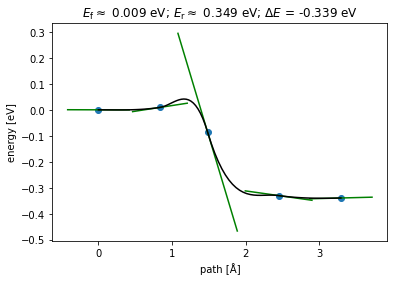

In [295]:
images = read('neb.traj@-5:')

for image in images:
  print(image.get_total_energy())

nebtools = NEBTools(images)


# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
#fig.savefig('diffusion-barrier.png')

# Create a figure with custom parameters.
#fig = plt.figure(figsize=(5.5, 4.0))
#ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
#nebtools.plot_band(ax)
#fig.savefig('barrier.png')

-63.30522839143356
-63.30444939731183
-63.299956236999435
-63.28158729220365
-63.31238859063842
-63.591509876729845
-63.61380104881283
-63.62814629375583
-63.63779075727382
-63.64299276225279
-63.6453413114171
-63.64455125178961


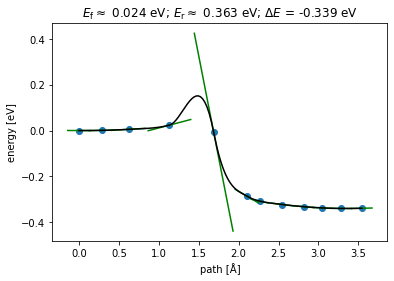

In [300]:
images = read('neb.traj@-12:')

for image in images:
  print(image.get_total_energy())

nebtools = NEBTools(images)


# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the barrier without any interpolation between highest images.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
#fig.savefig('diffusion-barrier.png')

# Create a figure with custom parameters.
#fig = plt.figure(figsize=(5.5, 4.0))
#ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
#nebtools.plot_band(ax)
#fig.savefig('barrier.png')